<a href="https://colab.research.google.com/github/erikaminarikova/REFRESH/blob/main/Example_9_ordinal_sums_titanic_data_2classes_different_learning_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 7.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pygad
import numpy as np
import pandas as pd
import statistics
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import image
import seaborn as sns

In [4]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy import stats
import time

In [5]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_squared_error

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [ ]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = []):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = np.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: math.exp2(np.abs(row['value'] - row['target']))/len(df), axis=1)
        fitness1 = 1/math.sqrt(sum(df['error']))
        df['calc_value_class'] = df.apply(lambda row: 0 if (row['value']<0.5) else 1, axis=1)
        df['target'] = df.apply(lambda row: 0 if (row['target']<0.5) else 1, axis=1)
        fitness2 = accuracy_score(df[['calc_value_class']].values, df[['target']].values)
        fitness = fitness1 + fitness2
        return fitness

    fitness_function = fitness_func

    num_generations = 60
    num_parents_mating = 12

    sol_per_pop = 24
    num_genes = 12 #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 2

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 15

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=[{'low': 0, 'high': 1},{'low': 0, 'high': 3},
                                        {'low': 0, 'high': 3},{'low': 0, 'high': 1},
                                        [0,1], [0,1], [0,1], [0,1],
                                        [0,1], [0,1], [0,1], [0,1]])

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    #filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= np.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-6:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    # merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [67]:
# Optimized and safe version
import numpy as np
import math
import pygad
import statistics
import pandas as pd
from sklearn.metrics import f1_score

# ---- Ordinal Sums Functions ---- #
def yes_function(x, y, a, kappa, lam, gamma=1):
    return 1 - np.maximum(0.0, ((1-x)**kappa + (1-y)**kappa - (1-a)**kappa))**(1/kappa)

def no_function(x, y, a, kappa, lam, gamma=1):
    return np.maximum(0.0, (x**lam + y**lam - a**lam))**(1/lam)

def maybe_function(x, y, a, kappa, lam, gamma=1):
    if x is None or y is None:
        return 0
    if gamma == 0:
        return 0
    else:
        value = gamma*(1/a)*x*y + (1-gamma)*(1 - (1/(1-a))*(1-x)*(1-y))
    return statistics.median([0, 1, value])

def classification(x, y, a, kappa, lam, gamma):
    if x < a and y < a:
        return no_function(x, y, a, 1, lam, 1)
    elif x > a and y > a:
        return yes_function(x, y, a, kappa, 1, 1)
    else:
        return maybe_function(x, y, a, 1, 1, gamma)

# ---- Vectorized wrapper ---- #
def classification_vec(values, diffs, a, kappa, lam, gamma):
    if values.size == 0 or diffs.size == 0:
        return np.zeros_like(values)

    results = np.zeros_like(values)
    mask_no = (values < a) & (diffs < a)
    mask_yes = (values > a) & (diffs > a)
    mask_maybe = ~(mask_no | mask_yes)

    if np.any(mask_no):
        results[mask_no] = no_function(values[mask_no], diffs[mask_no], a, 1, lam, 1)
    if np.any(mask_yes):
        results[mask_yes] = yes_function(values[mask_yes], diffs[mask_yes], a, kappa, 1, 1)
    if np.any(mask_maybe):
        for idx in np.where(mask_maybe)[0]:
            results[idx] = maybe_function(values[idx], diffs[idx], a, 1, 1, gamma)

    return np.round(results, 4)

# ---- Genetic Algorithm ---- #
def calculate_param_using_gen_alg(data: pd.DataFrame):
    df = data.copy()
    X = df.iloc[:, :-1].to_numpy()
    y = df.iloc[:, -1].to_numpy()
    n_features = X.shape[1]

    def fitness_func(ga_instance, solution, solution_idx):
        try:
            param = np.array(solution, dtype=float)
            value = np.abs(X[:, 0] - param[5])
            i = 6
            for j in range(n_features-1):
                diff = np.abs(X[:, j+1] - param[i])
                value = classification_vec(value, diff,
                                           param[0], param[1], param[2], param[3])
                i += 1

            error = np.exp2(np.abs(value - y))
            fitness1 = 1.0 / (math.sqrt(np.mean(error)) + 1e-8)  # avoid division by zero

            calc_class = (value >= param[0]).astype(int)
            target_class = (y >= param[0]).astype(int)
            fitness2 = f1_score(target_class, calc_class)

            if np.isnan(fitness1) or np.isnan(fitness2):
                return 0

            return param[4]*fitness1 + (1-param[4])*fitness2

        except Exception as e:
            print(f"Fitness calculation failed: {e}")
            return 0

    ga_instance = pygad.GA(
        num_generations=60,
        num_parents_mating=12,
        fitness_func=fitness_func,
        sol_per_pop=24,
        num_genes=9,
        init_range_low=0,
        init_range_high=1,
        parent_selection_type="tournament",
        K_tournament=3,
        keep_parents=2,
        crossover_type="single_point",
        mutation_type="random",
        mutation_percent_genes=15,
        gene_space=[
            {'low': 0.3, 'high': 0.7},   # a
            {'low': 0, 'high': 3},       # kappa
            {'low': 0, 'high': 3},       # lambda
            {'low': 0, 'high': 1},       # gamma
            {'low': 0, 'high': 1},       # fitness weight
            *([[0,1]] * 4)               # binary params
        ]
    )

    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    best_params = np.array(solution, dtype=float)
    value = np.abs(X[:, 0] - best_params[5])
    i = 6
    for j in range(n_features-1):
        diff = np.abs(X[:, j+1] - best_params[i])
        value = classification_vec(value, diff,
                                   best_params[0], best_params[1], best_params[2], best_params[3])
        i += 1

    error = np.exp2(np.abs(value - y))
    calc_class = (value >= best_params[0]).astype(int)
    target_class = (y >= best_params[0]).astype(int)

    df["calc_value"] = value
    df["error"] = error
    df["calc_value_class"] = calc_class
    df["target_class"] = target_class

    mean_error = np.mean(error)

    return (
        df,                # dataset with calc values
        mean_error,
        best_params[1],    # kappa
        best_params[2],    # lambda
        best_params[3],    # gamma
        best_params[0],    # a
        best_params,       # full parameter vector
        solution_fitness,
        solution_idx
    )


In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [10]:
def print_attr_coef(sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = data.drop(columns=['target']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in merge_list:
    print(list)

In [11]:
def view_chart(a, kappa, lam):
    """ if df:
        variables_for_plot = st.multiselect('Select 2 dependent variables for plot:', df.columns, max_selections=2)
        if variables_for_plot:
            df_for_plot = df[variables_for_plot]
            x=df_for_plot.iloc[:, 0]
            y=df_for_plot.iloc[:, 1]
            plt.scatter(x,y) """
    plt.figure(figsize=(3, 3))
    plt.subplot(111)
    y = np.arange(0, 1, 0.05)
    x = [a] * len(y)
    plt.scatter(x, y, c = 'black', s = 1)

    x = np.arange(0, 1, 0.05)
    y = [a] * len(x)
    plt.scatter(x, y, c = 'black', s = 1)

    y1 = np.arange(a, 1.0, 0.001)
    b=1
    x1 = 1-((1-a)**kappa-(1-y1)**kappa)**(1/kappa)
    plt.plot(x1, y1, c = 'red')
    plt.fill_between(y1,x1, b, color='red')

    y2 = np.arange(0, a, 0.01)
    x2 = ((a**lam)-(y2**lam))**(1/lam)
    plt.plot(y2, x2, c = 'green')
    plt.fill_between(y2,x2,color='green')

    # y3 = np.arange(a, 1.01, 0.01)
    # x3 = 1-(((1-a)**kappa)-((1-y3)**kappa))**(1/kappa)
    # z = np.min(b, x2)
    # plt.fill_between(y3,x3,y2=0, color='blue')

    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.annotate('D', xy=(a, a), xytext=(a + 0.2, a + 0.2), fontsize=12)
    plt.annotate('C', xy=(a, a), xytext=(a - 0.3, a - 0.3), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a - 0.3, a + 0.2), fontsize=12)
    plt.annotate('Avg', xy=(a, a), xytext=(a + 0.2, a - 0.3), fontsize=12)

    plt.annotate('a', xy=(a, a), xytext=(a - 0.04, a - 0.63), fontsize=12)
    plt.annotate('a', xy=(a, a), xytext=(a - 0.63, a - 0.04), fontsize=12)

    return (plt)

In [68]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic_data_train.csv', sep=',')

In [46]:
data.describe()

,age,fare,pclass,sex,target
count,485.000000,485.000000,485.000000,485.000000,485.000000
mean,0.432738,0.275058,0.710309,0.329897,0.379381
std,0.210663,0.206314,0.376336,0.470661,0.485734
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.307958,0.114358,0.500000,0.000000,0.000000
50%,0.418056,0.187590,1.000000,0.000000,0.000000
75%,0.559610,0.378788,1.000000,1.000000,1.000000
max,0.984272,1.000000,1.000000,1.000000,1.000000


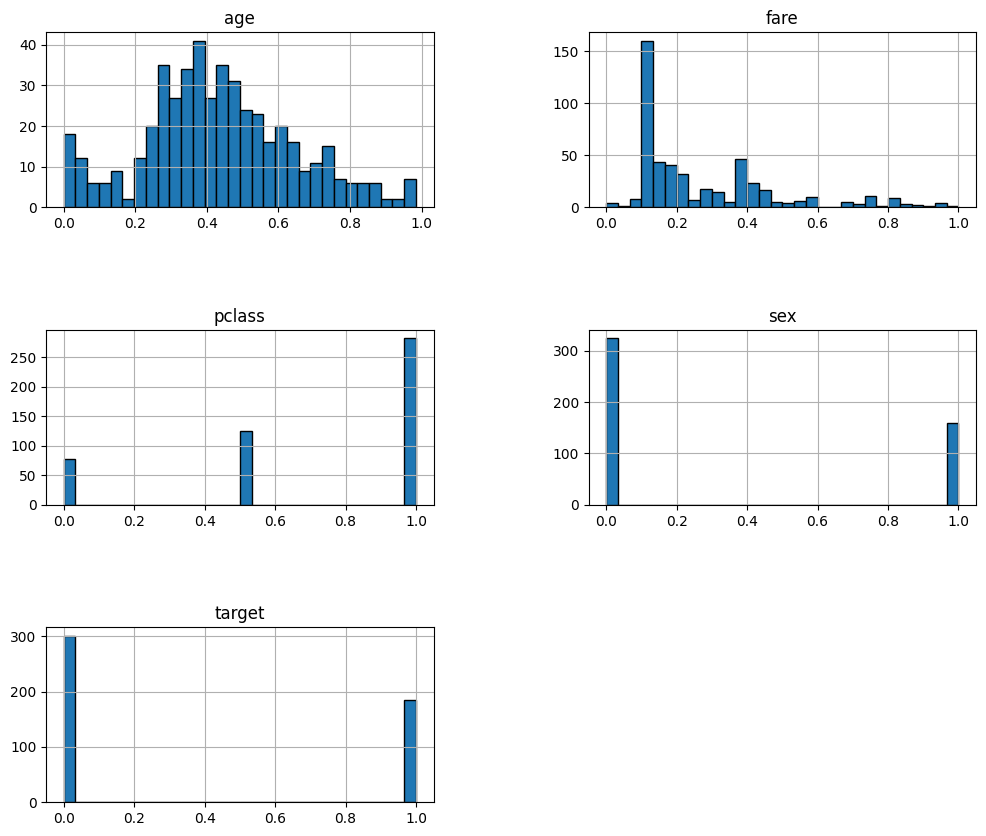

In [14]:
# Grafical representation of distribution of attributes
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [69]:
df_train = data

In [70]:
start_time = time.time()
merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(df_train)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(sol_param)
print("wages: {w1}, {w2}".format(w1=sol_param[4], w2=1-sol_param[4]))
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('time:', (time.time()-start_time)/60)

Results:
          age      fare  pclass  sex  target  calc_value     error  \
0    0.905631  0.383117     0.0    1       1      1.0000  1.000000   
1    0.449512  0.961039     0.0    0       0      0.5751  1.489781   
2    0.512425  0.072150     0.0    0       0      0.2706  1.206309   
3    0.370871  0.137085     1.0    0       0      0.0000  1.000000   
4    0.622523  0.223665     1.0    0       0      0.0000  1.000000   
..        ...       ...     ...  ...     ...         ...       ...   
480  0.323687  0.110390     1.0    1       1      0.5751  1.342479   
481  0.866310  0.116162     1.0    0       0      0.0000  1.000000   
482  0.433784  0.182540     0.5    1       1      0.9516  1.034117   
483  0.355143  0.108947     1.0    1       1      0.5751  1.342479   
484  0.567474  0.375180     0.5    0       0      0.0086  1.005979   

     calc_value_class  target_class  
0                   1             1  
1                   1             0  
2                   0             0 

In [21]:
def calculate_tests(target_values, value):
  print('Accuracy score = ', accuracy_score(target_values, value))
  print('F1 = ', f1_score(target_values, value, average= 'macro'))
  print('Precision = ', precision_score(target_values, value, average= 'macro'))
  print('Recall = ', recall_score(target_values, value, average= 'macro'))
  #confusion matrix
  confusion_matrix = metrics.confusion_matrix(target_values, value)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
  cm_display.plot()
  plt.show()

Accuracy score =  0.7793814432989691
F1 =  0.7695859695859696
Precision =  0.7747273580817564
Recall =  0.7665457921659309


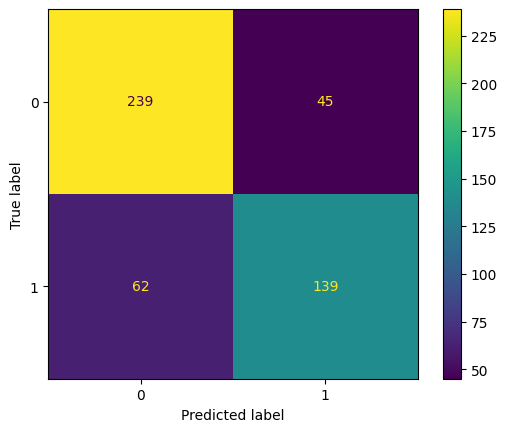

In [71]:
# tests for train dataset: testing_df
calculate_tests(merge_data[["calc_value_class"]].values, merge_data[['target_class']].values)

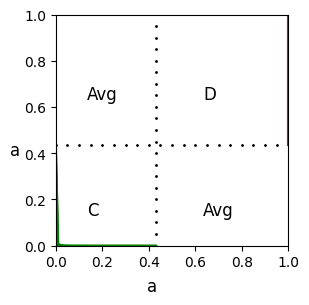

In [84]:
# df = pd.DataFrame()
# chart = view_chart(df, 0.2305, 0.8658, 3.7278, 0.9559)
# chart = view_chart(0.5,1,1)

chart = view_chart(a_result, lam_result, kappa_result)
chart.show()

In [79]:
#to know -2 or -5 in loop - remove additional columns
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/titanic_data_test.csv', sep=',')
df_test

,age,fare,pclass,sex,target
0,0.276502,0.119769,1.0,0,0
1,0.433784,0.375180,0.5,1,1
2,0.307958,0.141775,1.0,1,0
3,0.323687,0.114358,1.0,0,0
4,0.638251,0.291667,1.0,1,0
...,...,...,...,...,...
117,0.370871,1.000000,0.0,1,1
118,1.000000,0.375180,0.0,0,0
119,0.669707,0.676768,1.0,1,0
120,0.543882,0.151515,0.5,0,0


In [80]:
# Calculate ordinal sums on test dataset
columns=len(df_test.columns)
df_test['calc_value']=df_test.apply(lambda row: abs(sol_param[5]-row[0]), axis =1)
# parameters for attributes
i=6
j=0
while j < columns-2:
  df_test['calc_value']=df_test.apply(lambda row: classification(row['calc_value'], abs(row[j+1]-sol_param[i]), sol_param[0], sol_param[1], sol_param[2], sol_param[3]), axis = 1)
  print(sol_param[i])
  i += 1
  j += 1
show_results(df_test, 0, 0, 0, 0, 0)

0.0
1.0
0.0
Results:
          age      fare  pclass  sex  target  calc_value
0    0.276502  0.119769     1.0    0       0    0.000000
1    0.433784  0.375180     0.5    1       1    1.000000
2    0.307958  0.141775     1.0    1       0    0.575066
3    0.323687  0.114358     1.0    0       0    0.000000
4    0.638251  0.291667     1.0    1       0    0.575066
..        ...       ...     ...  ...     ...         ...
117  0.370871  1.000000     0.0    1       1    1.000000
118  1.000000  0.375180     0.0    0       0    0.143982
119  0.669707  0.676768     1.0    1       0    0.716015
120  0.543882  0.151515     0.5    0       0    0.000000
121  0.622523  0.187590     0.5    1       1    0.801412

[122 rows x 6 columns]
γ =  0
λ =  0
κ =  0
a =  0
Mean squared error =  0.1587
Root Mean Square Error =  0.3983


In [40]:
print(classification(1,1   , sol_param[0], sol_param[1], sol_param[2], sol_param[3]))

0.041894797687861154


In [35]:
print(classification(1,0, 0.5,1, 1, 0.5 ))

0.5


In [29]:
df_test

,age,fare,pclass,sex,target,calc_value,calc_value_class
0,0.905631,0.383117,0.0,1,1,0.000000,0
1,0.449512,0.961039,0.0,0,0,0.012369,0
2,0.512425,0.072150,0.0,0,0,0.041790,0
3,0.370871,0.137085,1.0,0,0,1.000000,1
4,0.622523,0.223665,1.0,0,0,1.000000,1
...,...,...,...,...,...,...,...
480,0.323687,0.110390,1.0,1,1,0.012369,0
481,0.866310,0.116162,1.0,0,0,1.000000,1
482,0.433784,0.182540,0.5,1,1,0.012369,0
483,0.355143,0.108947,1.0,1,1,0.012369,0


In [81]:
df_test['calc_value_class'] = df_test.apply(lambda row: 0 if (row['calc_value']<a_result) else 1, axis=1)

0.4331385653155764


,age,fare,pclass,sex,target,calc_value,calc_value_class
0,0.276502,0.119769,1.0,0,0,0.000000,0
1,0.433784,0.375180,0.5,1,1,1.000000,1
2,0.307958,0.141775,1.0,1,0,0.575066,1
3,0.323687,0.114358,1.0,0,0,0.000000,0
4,0.638251,0.291667,1.0,1,0,0.575066,1
...,...,...,...,...,...,...,...
117,0.370871,1.000000,0.0,1,1,1.000000,1
118,1.000000,0.375180,0.0,0,0,0.143982,0
119,0.669707,0.676768,1.0,1,0,0.716015,1
120,0.543882,0.151515,0.5,0,0,0.000000,0


In [82]:
#prepare test data for tests
target_values = df_test[['target']].values
value = df_test[['calc_value_class']].values

Accuracy score =  0.7786885245901639
F1 =  0.7534984659133428
Precision =  0.7443693693693694
Recall =  0.7850574712643679


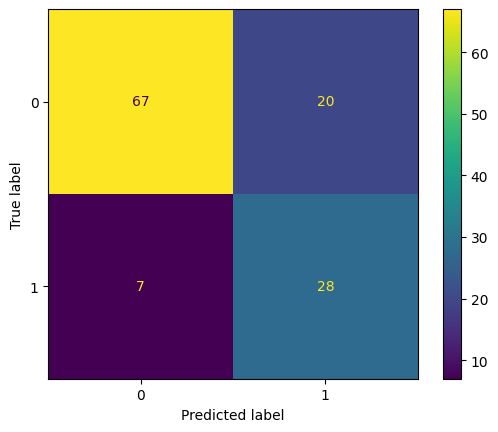

In [83]:
# tests for test dataset:
calculate_tests(target_values, value)

In [ ]:
merge_data.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output.csv')

In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/os_final_output_test.csv')